# 概率预报前需要的基本概念

本文简单补充一些概率预报相关的基本概念，这样才能更好地理解后续的知识。主要参考：

- [cpark321/uncertainty-deep-learning](https://github.com/cpark321/uncertainty-deep-learning)
- [Bayesian Neural Networks：贝叶斯神经网络](https://zhuanlan.zhihu.com/p/81170602)
- [A Beginner's Guide to Variational Methods: Mean-Field Approximation](https://blog.evjang.com/2016/08/variational-bayes.html)
- [ACM Computing Surveys文章：一文入门贝叶斯神经网络](https://www.linkresearcher.com/theses/9bad1d2b-e493-4d34-b298-1f32f7e64776)
- [Hands-on Bayesian Neural Networks -- a Tutorial for Deep Learning Users](https://arxiv.org/abs/2007.06823)

## MSE as MLE

了解概率预报中的基本概念 -- 最大似然估计

### MSE as Maximum Likelihood

- MSE(mean-squared error) 是一种常用的误差衡量方式，但是它就是公正的了么?
- 这里可以看到最小化MSE等价于最大化一个线性高斯模型的Likelihood 似然

假设数据由线性模型 $\mathbf{y} = \mathbf{wX}+ \epsilon$ 描述, 其中， $\epsilon_i \sim N(\epsilon_i; 0,\sigma^2_e)$ 

<img src=attachment:image.png width=350>
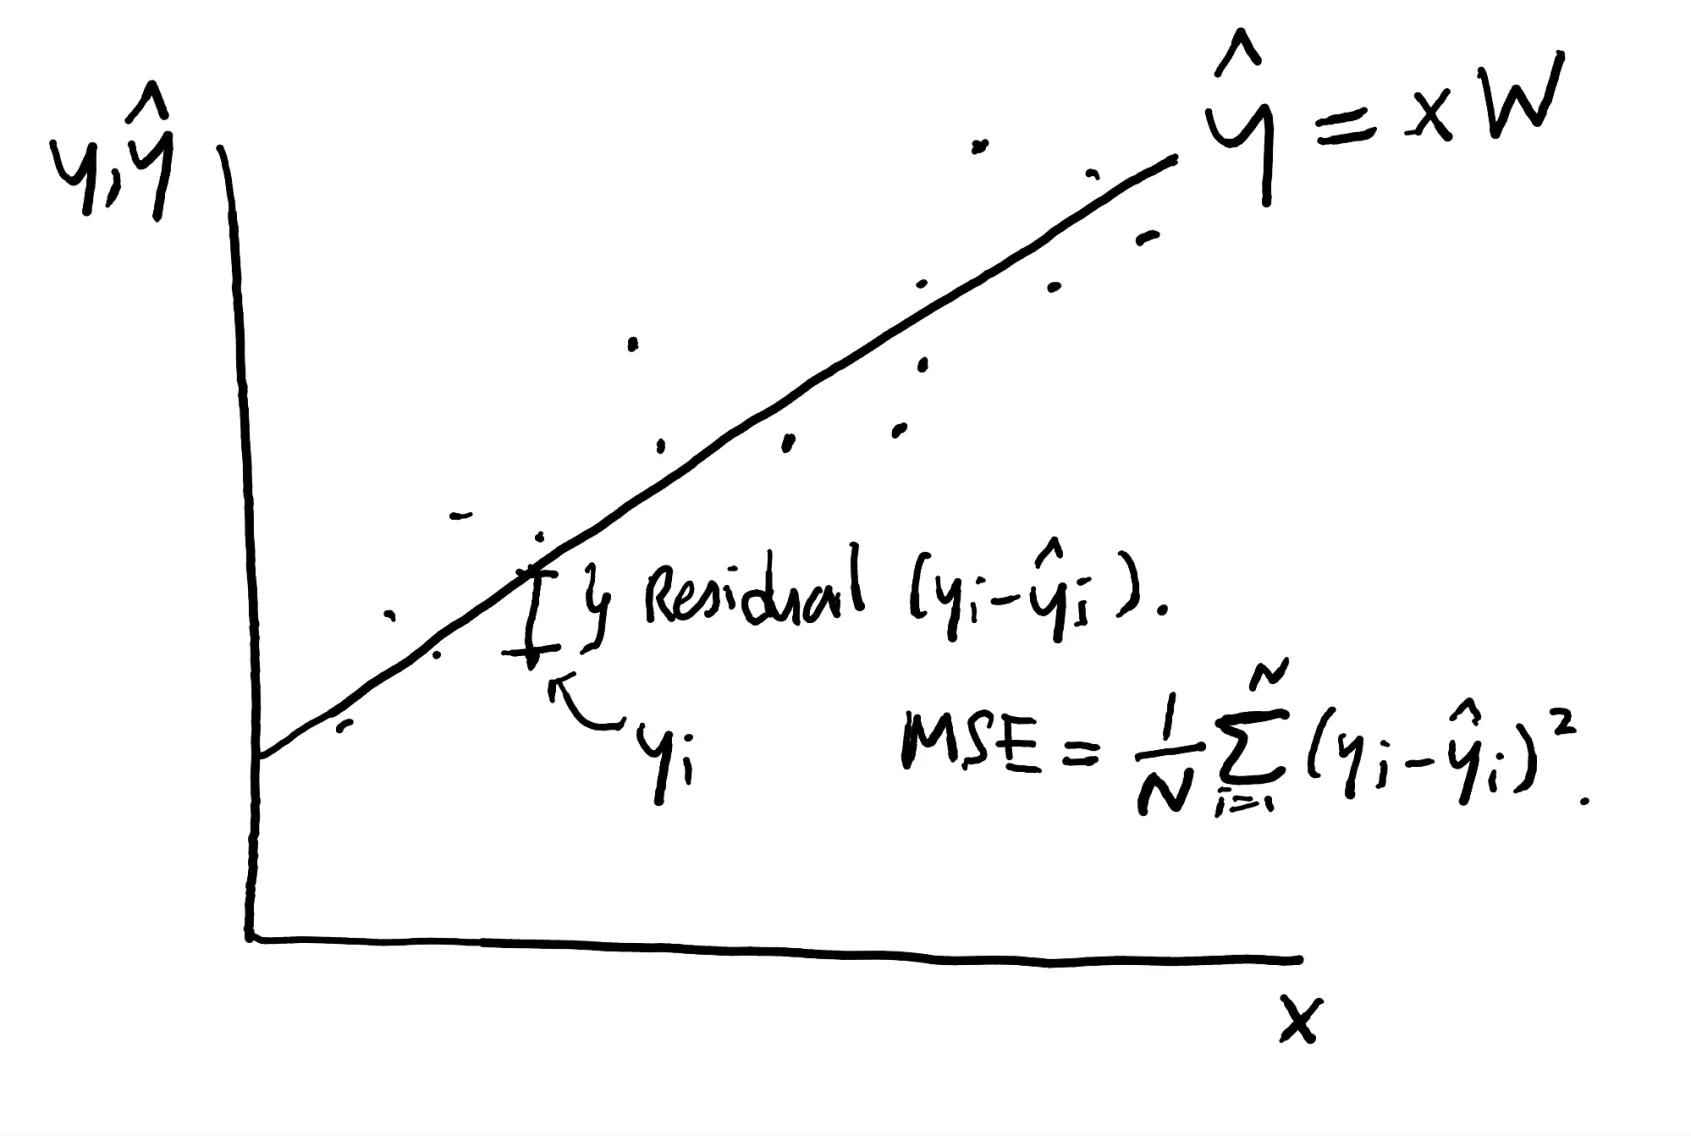

- Likelihood 就是给定模型参数（这里是 $\mathbf{w}$） 数据的概率

- log likelihood 就是：

$$\log p(\mathbf{y}|\mathbf{X, w}) = \sum_{i=1}^N \log p(y_i | \mathbf{x_i, \theta})$$

既然噪音 $\epsilon$ 是 Gaussian (i.e. normally distributed), 那么 likelihood 就是：

$$ \begin{aligned}  \log p(\mathbf{y}|\mathbf{X, w}) &= \sum_{i=1}^N \log N(y_i;\mathbf{x_iw},\sigma^2) \\  &= \sum_{i=1}^N \log \frac{1}{\sqrt{2\pi\sigma^2_e}}\exp (-\frac{(y_i - \mathbf{x_iw})^2}{2\sigma^2_e}) \\  &= -\frac{N}{2}\log 2\pi\sigma^2_e - \sum_{i=1}^N \frac{(y_i-\mathbf{x_iw)^2}}{2\sigma^2_e}  \end{aligned}$$

其中， N 是数据点的个数， 所以 参数最大似然估计：

$$\begin{aligned}  \mathbf{w}_{MLE} &= \arg\max_{\mathbf{w}} - \sum_{i=1}^N (y_i-\mathbf{x_iw})^2 \\  &= \arg\min_{\mathbf{w}} \frac{1}{N}\sum_{i=1}^N (y_i-\mathbf{x_iw})^2 \\  \end{aligned}$$

也就是前面说的最小化MSE等价于最大化一个线性高斯模型的Likelihood

### Maximum Likelihood as minimising KL Divergence

- KL Divergence 衡量的是两个概率分布之间的不相似性：

$$D_{KL}(p||q) = E_{\mathbf{x}\sim p(\mathbf{x})}[\log p(\mathbf{x})-\log q(\mathbf{x})]$$ 

- 最小化经验分布$\hat{p}_{\text{data}}$和 模型分布 $p_{\text{model}}$之间的 KL divergence：

$$\begin{aligned}  \theta_{\text{min KL}} &= \arg\min_{\theta} D_{KL}(\hat{p}_{\text{data}} || p_{\text{model}}) \\  &= \arg\min_{\theta} E_{\mathbf{x}\sim{\hat{p}_{\text{data}}}}[\log \hat{p}_\text{data}(\mathbf{x})-\log p_{\text{model}}(\mathbf{x})]  \end{aligned}$$

- 但 $E_{\mathbf{x}\sim{\hat{p}_{\text{data}}}}\log \hat{p}_\text{data}(\mathbf{x})$ 独立于模型参数 $\theta$, 所以:

$$\begin{aligned}  \theta_{\text{min KL}} &= \arg\min_{\theta} - E_{\mathbf{x}\sim{\hat{p}_{\text{data}}}}[\log p_{\text{model}}(\mathbf{x}|\theta)]  \end{aligned} $$

- 我们可以将负的 argmin 转为正的 argmax，并且如果数据点是独立同分布的话，就有:
$$\begin{aligned}  \theta_{\text{min KL}}&= \arg\max_{\theta} \lim\limits_{N\to\infty}\frac{1}{N}\sum_{i=1}^N\log(p(\mathbf{x_i}|\theta)) \\  &= \theta_{MLE}  \end{aligned}$$

## Bayes by Backprop (Weight Uncertainty in Neural Networks)

看一个例子

### Toy example

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

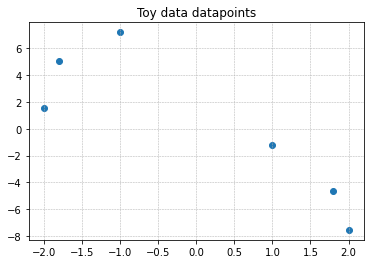

In [3]:
def toy_function(x):
    return -x**4 + 3*x**2 -5*np.sin(x) + 1

# toy dataset we can start with
x = torch.tensor([-2, -1.8, -1, 1, 1.8, 2]).reshape(-1,1)
y = toy_function(x)

plt.scatter(x, y)
plt.title('Toy data datapoints')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [6]:
class standard_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1,16)
        self.l2 = nn.Linear(16,16)
        self.l3 = nn.Linear(16,1)
    def forward(self, x):
        x = self.l3(torch.sigmoid(self.l2(torch.sigmoid(self.l1(x)))))
        return x

In [7]:
# initialization of our standard neural network
net1 = standard_MLP().to(device)

# use of a Mean Square Error loss to evaluate the network because we are in a regression problem
criterion = nn.MSELoss()

# use of stochastic gradient descent as our optimizer
optimizer = optim.SGD(net1.parameters(), lr=0.01)

# number of times we are looping over our data to train the network
epochs = 30000

for epoch in range(epochs):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net1(x.to(device))    # pass the data forward
    loss = criterion(output, y.to(device))   # evaluate our performance
    if epoch % 5000 == 0:
        print("epoch {} loss: {}".format(epoch,loss))
    loss.backward()  # calculates the gradients
    optimizer.step()    # updates weigths of the network

epoch 0 loss: 26.816816329956055
epoch 5000 loss: 1.0803192853927612
epoch 10000 loss: 0.36492207646369934
epoch 15000 loss: 0.15107035636901855
epoch 20000 loss: 0.04581207036972046
epoch 25000 loss: 0.007232772186398506


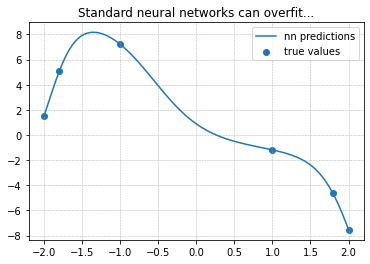

In [8]:
x_test = torch.linspace(-2,2,100).reshape(-1,1)
predictions = net1(x_test.to(device))
plt.plot(x_test.numpy(), predictions.cpu().detach().numpy(), label = 'nn predictions')
plt.scatter(x, y, label = 'true values')
plt.title('Standard neural networks can overfit...')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

- 当我们扩展预测到我们的数据范围之外时，我们可以清楚地看到我们过拟合了这6个数据。
    - 变差是因为扩展了范围的x值被视为“超出分布范围”。
    - 在没有任何训练数据的情况下进行了过度自信的概括

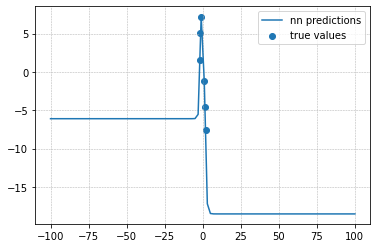

In [9]:
x_test = torch.linspace(-100,100,100).reshape(-1,1)
predictions = net1(x_test.to(device))
plt.plot(x_test.numpy(), predictions.cpu().detach().numpy(), label = 'nn predictions')
plt.scatter(x, y, label = 'true values')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## 随机神经网络

![](img/p5uh7g8z-a4fr-hkt5-8zys-u5x3mw74)

从统计学的角度对神经网络进行分类。图片出处：论文 Hands-on Bayesian Neural Networks -- a Tutorial for Deep Learning Users

一个给定的神经网络体系结构代表了一组与可能的系数同构的函数，而 θ 代表了网络的所有权重和偏置量。深度学习是对训练数据 D 上的参数 θ 回归的过程。标准方法是使用反向传播算法估算最小成本点（Min COST, Minimal Cost Point）。代价函数通常定义为训练集的对数似然函数，有时用正则项来惩罚参数化。

从统计学家的观点来看，一个神经网络模型可以视为一个条件分布模型 p(y|x,w) ：输入 x ，输出预测值 y 的分布， w 为神经网络中的权重。在分类问题中这个分布对应各类的概率，在回归问题中一般认为是（标准差固定的）高斯（Gaussian）分布并取均值作为预测结果。相应地，神经网络的学习可以视作是一个最大似然估计（Maximum Likelihood Estimation, MLE）：

![](img/equation.svg)

其中 $\mathcal D$ 对应我们用来训练的数据集（dataset）。回归问题中我们代入高斯分布就可以得到平均平方误差（Mean Squared Error, MSE），分类问题则代入逻辑函数（logistic）可以推出交叉熵（cross-entropy）。求神经网络的极小值点一般使用梯度下降，基于反向传播（back-propagation， BP）实现。

MLE 中不对 w 的先验概率作假设，也就是认为 w 取什么值的机会都均等。如果为 w 引入先验，那就变成了最大后验估计（Maximum Posteriori, MAP）：

![](img/equation1.svg)

代入高斯分布可以推出 L2 正则化（倾向于取小值），代入拉普拉斯分布（Laplace）可以推出 L1 正则化（倾向于取 0 使权重稀疏）。

使用现代算法和工具包的点估计方法相对容易，但往往缺乏可解释性，并可能以不可预见和过于自信的方式对非训练分布数据点进行泛化。一旦预测在某些领域具有决定意义时，这种特性，以及 ANN 无法回答 “I don’t know” 的问题，是存在很大风险的。这些是引入随机神经网络的主要动机之一。

![](img/456hub2j-bjxy-vehg-hjek-hc5gltp1)

点估计神经网络，只学习一组权重；(b) 随机激活神经网络，只学习一组权重以及激活的概率分布；(c) 随机系数神经网络，在权重上学习一个概率分布。图片出处：论文 Hands-on Bayesian Neural Networks -- a Tutorial for Deep Learning Users

随机神经网络是一种通过在网络中引入随机成分来模拟多种可能模型 θ 及其相关概率分布 p (θ) 而建立的神经网络。

因此，可以把它们视为集成学习的特例，区别于训练单一模型，而是训练一组模型并汇总其预测。

谈到集成学习，其背后的主要动机来自于以下观察：首先，聚集大量表现平均但独立的变量的预测所得出之结果，比单个表现良好的专家预测变量的输出要好得多。

其次，随机神经网络也可以以类似的方式使用。尽管没有证据表明使用随机神经网络是提高准确性的最佳方法，但已经观察到的是，它们的预测确实比点估计的预测更好。最后，使用随机神经网络结构的主要目的是更好地了解与潜在过程相关的不确定性。这是通过比较多采样模型参数化的预测来实现的。如果不同的模型 agree，那么不确定性就很低，反之，则很高。此过程可以总结如下：

![](img/iq0rz632-w5kj-adg4-3yxs-f73k0er5)(3)

# 贝叶斯神经网络 Bayesian NN

那么贝叶斯神经网络与随机神经网络有何关系呢？

BNN 可以定义为使用贝叶斯推理训练的任意随机人工神经网络。设计 BNN 的步骤如下，首先选择深度神经网络架构，即功能模型；然后，必须选择一个随机模型，即可能的模型参数先验分布$p(\theta)$和对模型$p(y|x,\theta)$的预测能力进行先验信心 (下图 a)。随后，应用贝叶斯定理，令模型参数与输入之间独立，则容易得到贝叶斯后验概率为：

![](img/8iu5tb9k-94g1-e4h2-rnok-vo231hi7)

其中，$D_x$表示训练的feature，$D_y$表示训练的label

计算这个分布，或者说用一般的标准方法从它采样难度较大（intractable），尤其是计算分母（称之为evidence）很难。解决这个问题的方案通常有两种：第一种是采用马尔科夫链蒙特卡洛方法（MCMC, Markov Chain Monte Carlo），该算法允许直接对后验样本进行采样，但需要对样本集$\Theta$进行缓存；第二种方法是使用变分推理方法，它学习变分分布$q_{\phi}(\theta)$来近似精确的后验概率。如上述公式的分母所示，这两种方法都绕过了对 evidence 的计算，这就解释了为什么后验通常给定为比例常数。

![](img/QQ截图20210623172533.jpg)

给定贝叶斯后验概率或其变分近似，就可以在给定特定输入的情况下计算输出的边际概率分布，从而准确量化模型的不确定性：

![](img/bc9el6tj-y1xl-6dna-kgdi-ytcp94nb)

当然实际中，这个分布也不是直接计算的，也是间接利用公式(3)采样得到的。$\theta$从变分分布$q_{\phi}(\theta)$采样或者从参数集中均匀采样。最后的预测是通过使用蒙特卡洛方法计算的统计值总结得到的（上图c）。

为了总结用于执行回归的 BNN 的预测，通常的过程是执行贝叶斯模型平均（Bayes model averaging），此方法在集成学习中的应用非常普遍：

![](img/16isqe97-zxy5-ktqm-hrt0-n8iybdvj)

为了量化不确定性，协方差矩阵计算如下：

![](img/p6ljo4vm-q8bs-651a-8ha2-hatfsjg1)

### 变分方法

贝叶斯估计求出 w 的后验分布 $p(w|\mathcal D)$ ，而不限于 argmax 值，这样我们就可以为神经网络的预测引入不确定性。由于我们求得的是分布，基于 w 由输入 $\hat x$ 预测 $\hat y$ 的概率模型就变成了：

![](img/equation2.svg)

这样我们每次预测 $\hat y$  都得求个期望，问题是这个期望我们并不可能真的算出来，因为这就相当于要计算在 $p(w|\mathcal D)$ 上的所有可能的神经网络的预测值。

另一方面，求后验分布 $p(w|\mathcal D)$ 也是件麻烦的事情。众所周知，根据贝叶斯理论，求 $p(w|\mathcal D)$ 需要通过：

![](img/equation3.svg)

这东西也是难解（intractable）的。

所以，为了在神经网络中引入贝叶斯估计，需要找到方法近似这些东西，并且最好能转化成为求解优化（optimization）问题的形式，这样比较符合众炼丹师们的追求。

变分贝叶斯 (VB) 方法是统计机器学习中非常流行的一系列技术。VB 方法允许我们将统计推理 问题（即在给定另一个随机变量的值的情况下推断关注的随机变量的值）重写 为优化 问题（即找到使某些目标函数最小化的参数值）。

这种推理-优化二元性很强大，因为它允许我们使用最新最好的优化算法来解决统计机器学习问题（反之亦然，可以使用统计技术最小化函数）。

下面看最简单的 VB 方法的优化目标，称为平均场近似Mean-Field Approximation。这个目标，也称为 变分下界Variational Lower Bound，与变分自动编码器中使用的目标完全相同（后续解释，待补充）。

首先是一些约定的标记：

- 大写 X 表示随机变量
- 大写 P(X) 表示该变量的概率分布
- 小写 x ∼ P(X) 表示，通过一些生成过程，一个值 x 采样（～）自 概率分布 P(X) 。
- 小写 p(X) 是X分布的密度函数. 它是X测度空间上的标量函数.
- p(X=x) （简写为 p(x)) 表示在特定值x处评估的密度函数. 

许多学术论文交替使用术语“变量”、“分布”、“密度”，甚至“模型”。这本身不一定是错误的，因为X, P(X)， 和 p(X)所有这些都通过一一对应的方式相互暗示。 但是，将这些词混合在一起会令人困惑，因为它们的类型不同（对函数进行采样没有意义，对分布进行积分也没有意义）。 

我们将系统建模为随机变量的集合，其中一些变量（X) 是“可观测的”，而其他变量 (Z) 是“隐藏的”。我们可以通过下图画出这种关系：

![](img/presentation.png)

从 Z 到 X 的箭头线通过条件分布 P(X|Z)将两个变量联系在一起.

这有一个更具体的例子： X 可能代表“图像的原始像素值”，而 Z 是一个二元变量，比如如果“ X 是一只猫的形象”，那么 Z= 1 

X= ![](img/Zack-Fat-Cat-1024x675.jpg)

P(Z=1)=1 (definitely a cat)

X=![](img/brown-sugar-ice-cream-1a.jpg)

P(Z=1)=0 (definitely not a cat)

X= ![](img/9ffbb78f65b5d829a91ca082211f116c.jpg)

P(Z=1)=0.1 (sort of cat-like)

贝叶斯定理为我们提供了任意一对随机变量之间的一般关系：

$$p(Z|X) =\frac{p(X|Z)p(Z)}{p(X)}$$


这其中的各个部分都与通用名称相关联：

p ( Z| X)是**后验概率**posterior probability：“给定图像，这是一只猫的概率是多少？” 如果我们可以从z～P( Z| X)采样，我们可以用它来制作一个猫分类器，告诉我们给定的图像是否是一只猫。

p ( X| Z)是**似然**likelihood：“给定值Z，似然计算了此图像X属于某个类别 ({"is-a-cat" / "is-not-a-cat"})的“可能性”。如果我们可以从x ∼ P( X| Z)采样，然后我们可以像生成随机数一样轻松地生成猫的图像和非猫的图像。

p ( Z)是**先验概率**prior probability。这捕获了我们所知道的任何先验信息Z - 例如，如果我们认为存在的所有图像中有 1/3 是猫，那么 p ( Z= 1 ) =1/3 和 p ( Z= 0 ) =2/3.

我们感兴趣的关键问题是后验推理，或隐藏变量Z的计算函数。 后验推理的一些典型例子：

- 鉴于这段监控录像 X，嫌疑人出现在里面了吗？
- 鉴于此推特提要 X，作者心情郁闷吗？
- 鉴于历史股价 $X_{1 : t − 1}$，$X_t$会是什么？

我们通常假设我们知道如何在似然函数P( X| Z) 和先验 P( Z)上计算函数.

问题是，对于像上面这样的复杂任务，我们经常不知道如何从P( Z| X)采样 或如何计算 p ( X| Z). 或者，我们可能知道p ( Z| X)的形式，但相应的计算是如此复杂，以至于我们无法在合理的时间内对其进行评估。我们可以尝试使用基于采样的方法，如MCMC，但这些方法收敛速度很慢。

Variational Inference变分推理背后的想法是：让我们对简单的参数化的分布$Q_{\phi}( Z| X)$ （如高斯）(我们知道如何进行后验推断)进行推理，但调整参数 φ 以便 $Q_{\phi}$ 尽可能接近 P。

如下图所示：蓝色曲线是真实的后验分布，绿色分布是我们通过优化拟合到蓝色密度的变分近似（高斯）。

![](img/presentation1.png)

所以这里就用到KL散度来判断两个分布的相近程度。

### 变分推理 Variational Inference

利用变分（variational）的方法，我们可以使用一个由一组参数 $\theta$ 控制的分布 $q(w|\theta)$ 去逼近真正的后验 $p(w|\mathcal D)$ ，比如用高斯来近似的话 $\theta$ 就是 $\mu,\sigma$，这样就把求后验分布的问题转化成了求最好的 $\theta$ 这样的优化问题。这个过程可以通过最小化两个分布的 KL 散度（Kullback-Leibler divergence）实现。即我们的目标会变为最小化 $q(w \vert \theta)$ 和 $P(w \vert \mathcal{D})$ 之间的KL divergence。我们想找到这样的 $\theta^*$ 使得：

$$\theta^* = \underset{\theta}{\mathrm{argmin}} {D_{\text{KL}}}\left[q(w \vert \theta) \vert \vert P(w \vert \mathcal{D})\right]$$

继续运算下去如下所示：

\begin{aligned}
\theta^* &= \underset{\theta}{\mathrm{argmin}} D_{\text{KL}}\left[q(w \vert \theta) \vert \vert P(w \vert \mathcal{D})\right] & \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ }\int q(w \vert \theta)\log\frac{ q(w \vert \theta) }{P( w \vert \mathcal{D})}dw & \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ }\int q(w \vert \theta) \log\frac{ q(w \vert \theta)P(\mathcal{D}) }{P( \mathcal{D} \vert w)P(w)} dw & \text{(Bayes Theorem)} \\\\
&= \underset{\theta}{\mathrm{argmin}} \text{ }\int q(w \vert \theta) \log\frac{ q(w \vert \theta) }{P( \mathcal{D} \vert w)P(w)} dw & \text{(Drop }P(\mathcal{D})\text{ because it doesn't depend on } \theta) \\\\
&= \underset{\theta}{\mathrm{argmin}} D_{\text{KL}}\left[q(w \vert \theta) \vert \vert P(w)\right] - \mathbb{E}_{q(w \vert \theta)}\left[ \log P(\mathcal{D} \vert w) \right]
\end{aligned}

- $P(\mathcal{D} \vert w)$ 是给定权重下观测数据的似然
- $\text{ KL}\left[q(w \vert \theta) \vert \vert P(w)\right]$: 可以把这个 KL-divergence 项解释为一个 regularizer，它使 $q(w \vert \theta)$ 匹配先验 $P(w)$.
- **我们可以使用 back propagation 来最小化 关于 $\theta$ 的 KL divergence 吗?** 我们需要求期望的导数

写成目标函数（objective function）的形式就是：

![](img/equation4.svg)

这个其实仍然没法算出来，但是至少长得更像能算出来的东西。第一项就是我们的变分后验与先验的 KL 散度；第二项的取值依赖了训练数据。[Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424)中把第一项叫作复杂性代价（complexity cost），描述的是权重和先验的契合程度；把第二项叫作似然代价（likelihood cost），描述对样本的拟合程度。优化这个目标函数可以看作是炼丹师们最熟悉的正则化，在两种代价中取平衡。

对于 P(w) 的形式，[Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424)中给出了一个混合尺度高斯先验（scale mixture gaussian prior）：

![](img/equation5.svg)

即每个权重其分布的先验都是两种相同均值、不同标准差的高斯分布的叠加。

下一步要做的就是继续对目标函数取近似，直到能求出来为止。

蒙特卡罗方法（Monte Carlo method）是刻在炼丹师 DNA 里的方法。(1) 中有一个期望不好求，可以使用这种喜闻乐见的办法弄出来。

众所周知，同样利用贝叶斯估计推导出来的变分自编码器（Variational Auto-Encoder, VAE）[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)文中引入了一个妙不可言的重参数化（reparameterize）操作：对于 $z\sim\mathcal{N}(\mu,\sigma^2)$ ，直接从 $\mathcal{N}(\mu,\sigma^2)$ 采样（sample）会使得 $\mu$ 和 $\sigma$ 变得不可微；为了得到它们的梯度，将 z 重写为 $z=\sigma\epsilon +\mu$ ，其中 $\epsilon \sim \mathcal{N}(0,1)$ ，这样便可以先从标准高斯分布采样出随机量，然后可导地引入 $\mu$ 和 $\sigma$ 。

[Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424)对此进行了推广，证明了对一个随机变量$\epsilon$ 和概率密度 $q(\epsilon)$ ，只要能满足 $q(\epsilon)d\epsilon = q(w|\theta)dw$ ，则对于期望也可以使用类似操作得到可导的对期望偏导的无偏估计：

![](img/equation6.svg)

利用这一点可以得到 (1) 的蒙特卡罗近似：

![](img/equation7.svg) (2)

其中 $w^{(i)}$ 是处理第 i 个数据点时的权重采样。

[Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424)中提出的这个近似把 $\mathcal F (\mathcal D|\theta)$ 的 KL 项也给蒙特卡罗了，而其实对于很多先验形式这个 KL 项是可以有解析解的。它这么做的理由是为了配适更复杂的先验/后验形式。另一篇文章[Variational Dropout and the Local Reparameterization](https://arxiv.org/abs/1506.02557)只考虑高斯先验，于是在同样的证据下界中取了 KL 项的解析解。实践中可以根据使用的先验不同来取不同的近似。

理论有些复杂，但是code有完成好的可以借鉴：[JavierAntoran/Bayesian-Neural-Networks](https://github.com/JavierAntoran/Bayesian-Neural-Networks)

下面是延续上面示例的代码。

## 示例代码

牵涉到概率编程之前，需要一些基本概念。下面先看看PyTorch中一些基础程序的意思。

pytorch中基础的概率包是 distributions，该distributions包包含可参数化的概率分布和采样函数，允许构建用于优化的随机计算图和随机梯度估计器。因为直接在随机样本上执行反向传播是不行的，所以采用两种方式来处理，其一是Score function，另一个是Pathwise derivative。参考这里：https://pytorch.org/docs/stable/distributions.html

首先，Categorical 表示多维伯努利分布，sample表示采样一次

In [25]:
from torch import distributions as D
m = D.Categorical(torch.tensor([ 0.25, 0.25, 0.25, 0.25 ]))
m.sample()  # equal probability of 0, 1, 2, 3

tensor(3)

In [17]:
action_logits = torch.rand(5)
action_probs = F.softmax(action_logits, dim=-1)
action_probs

tensor([0.2678, 0.1893, 0.1180, 0.2561, 0.1688])

log_prob 就是计算概率的对数

In [22]:
dist = D.Categorical(action_probs)
action = dist.sample()

tensor(-1.6645) tensor(-1.6645)


In [23]:
action

tensor(1)

In [26]:
print(dist.log_prob(action), torch.log(action_probs[action]))

tensor(-1.6645) tensor(-1.6645)


接下来是正式的示例code

In [10]:
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, x):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()
        
        return F.linear(x, self.w, self.b)

In [11]:
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden1 = Linear_BBB(1,hidden_units, prior_var=prior_var)
        self.hidden2 = Linear_BBB(hidden_units,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden1.log_prior + self.hidden2.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden1.log_post + self.hidden2.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0]).to(device)
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function) 上面的式（2）
        loss = log_post - log_prior - log_like
        return loss

每层线性层内的计算是比较难理解的，但是外部的计算没有什么特别的，和一般的神经网络是一致的。

In [12]:
net = MLP_BBB(16, prior_var=1).to(device)

In [13]:
optimizer = optim.Adam(net.parameters(), lr=.1)

In [14]:
epochs = 2000
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(x.to(device), y.to(device), 1)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 7631.21826171875
epoch: 101/2000
Loss: 1383.0318603515625
epoch: 201/2000
Loss: 1299.59130859375
epoch: 301/2000
Loss: 1249.986328125
epoch: 401/2000
Loss: 739.8626708984375
epoch: 501/2000
Loss: 665.6658935546875
epoch: 601/2000
Loss: 867.1513671875
epoch: 701/2000
Loss: 919.905029296875
epoch: 801/2000
Loss: 505.8752746582031
epoch: 901/2000
Loss: 542.523193359375
epoch: 1001/2000
Loss: 475.1436462402344
epoch: 1101/2000
Loss: 479.3214416503906
epoch: 1201/2000
Loss: 600.5387573242188
epoch: 1301/2000
Loss: 449.8390808105469
epoch: 1401/2000
Loss: 460.20294189453125
epoch: 1501/2000
Loss: 628.2733154296875
epoch: 1601/2000
Loss: 492.14459228515625
epoch: 1701/2000
Loss: 509.7036437988281
epoch: 1801/2000
Loss: 457.0097961425781
epoch: 1901/2000
Loss: 449.801513671875
Finished Training


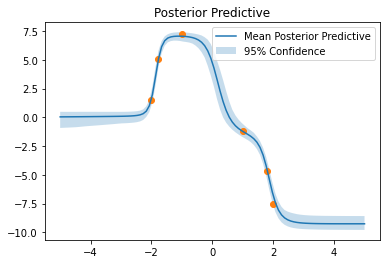

In [15]:
# samples is the number of "predictions" we make for 1 x-value.
samples = 100
x_tmp = torch.linspace(-5,5,100).reshape(-1,1).to(device)
y_samp = np.zeros((samples,100))
for s in range(samples):
    y_tmp = net(x_tmp).cpu().detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.cpu().numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.cpu().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()

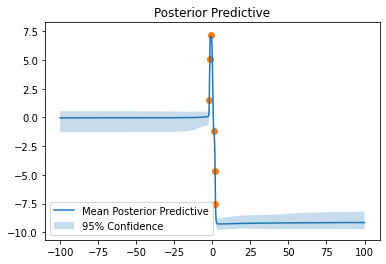

In [16]:
samples = 100
x_tmp = torch.linspace(-100,100,1000).reshape(-1,1).to(device)
y_samp = np.zeros((samples,1000))
for s in range(samples):
    y_tmp = net(x_tmp).cpu().detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.cpu().numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.cpu().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()